In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import multivariate_normal as mvn

plt.rcParams.update({'font.size': 22})

In [36]:
#import data training data
train = pd.read_csv('MNIST_train.csv', header = 0)

#import testing data
test =  pd.read_csv('MNIST_test.csv', header = 0)

#drop redundant columns with row index
train = train.drop(['Unnamed: 0','index'], axis=1)
test = test.drop(['Unnamed: 0','index'], axis=1)

In [41]:
#Check data types of data
print(train.dtypes)
print(test.dtypes)

#Check data for missing entries
print(train.columns[train.isnull().any()])
print(test.columns[test.isnull().any()])

labels    int64
0         int64
1         int64
2         int64
3         int64
          ...  
779       int64
780       int64
781       int64
782       int64
783       int64
Length: 785, dtype: object
labels    int64
0         int64
1         int64
2         int64
3         int64
          ...  
779       int64
780       int64
781       int64
782       int64
783       int64
Length: 785, dtype: object
Index([], dtype='object')
Index([], dtype='object')


In [34]:
#pick data rows of certain label
def select_label(data, label):

    return data[data['labels'] == label].drop(['labels'], axis=1)

#plot each observation in a grid
def plot_observation(data):
    
    #reshape to square
    data = np.reshape(data, (28, 28))
    
    #define figure
    fig, ax = plt.subplots()
    
    #plot pixels
    im = ax.imshow(data)
    
    #show figure
    plt.show()
    
# Create mean image from data of given label
def form_mean_image(data,label):
    
    # Select rows of certain label
    data = select_label(data, label)
    
    #convrt to numpy
    data = data.to_numpy()
    
    #calculate the mean of every column
    mean = np.mean(data, axis=0)
    
    #plot mean image
    plot_observation(mean)
    
#return accuracy for model
def accuracy(y, y_hat):
    
    # sums all values that are equal then divides by number of total values
    return np.mean(y==y_hat)

#split dependent and independent variables
def split_X_y(data):
    
    #convert to numpy array
    data = data.to_numpy()
    
    #create dependent variable
    X = data[:,1:]
    
    #create indepedent varaiables
    y = data[:,0]
    
    return X/255, y

# gennerates a confusion matrix from two arrays of equal length
def confusionMatrix(y,y_hat):
    
    #Generate empty matrix
    confuse = np.zeros((10,10),dtype=int)
    
    #loop through both arrays
    for i in range(len(y)):
    
        #increase count in entry of each label
        confuse[y[i],y_hat[i]] = confuse[y[i],y_hat[i]] +1
    
    #return as dataframe
    return pd.DataFrame(confuse)
    
    
    

In [5]:
class GaussBayes():
    
    def fit(self, X, y, epsilon = 1e-3):
        
        self.likelihoods = dict()
        self.priors = dict()
        self.K = set(y.astype(int))
        
        for k in self.K:
            
            X_k = X[y == k,:]
            N_k, D = X_k.shape
            mu_k = X_k.mean(axis = 0)
            
            self.likelihoods[k] = {'mean': X_k.mean(axis = 0),'cov':(1/(N_k-1))*np.matmul((X_k-mu_k).T, X_k - mu_k) +epsilon*np.eye(D)}
            self.priors[k] = len(X_k)/len(X)
    
    def predict(self, X):
    
        N, D =  X.shape
        P_hat = np.zeros((N,len(self.K)))
        
        for k,l in self.likelihoods.items():
            
            P_hat[:, k] = mvn.logpdf(X,l['mean'],l['cov'])+np.log(self.priors[k])
            
        return P_hat.argmax(axis=1)

In [26]:
class MultinomialNiaveBayes():

    def fit(self, X, y,epsilon = 1e-3):
        
        self.e = epsilon
        N, D = X.shape
        self.labels = np.unique(y)
        num_labels = len(self.labels)
    
        self.priors = np.zeros(num_labels)
        self.likelihoods = np.zeros((num_labels, D))
        
        for i , k in enumerate(self.labels):
            X_k = X[k == y]
            self.priors[i] = X.shape[0]/N
            self.likelihoods[i,:] = (X_k.sum(axis=0)+1)/ (np.sum(X_k.sum(axis=0)) + 1)

    def predict(self, X):
    
        preds = []
    
        for row in X:
        
            posterior = []
            for i, k in enumerate(self.labels):
                prior_k = np.log(self.priors[i])
                likelihoods_k = np.log(self.likelihoods[i,:]*row+ self.e)
                posterior_k = np.sum(likelihoods_k) + prior_k
                posterior.append(posterior_k)
            preds.append(self.labels[np.argmax(posterior)])
        
        return preds
    

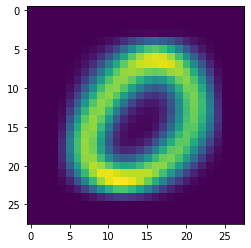

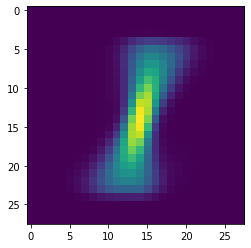

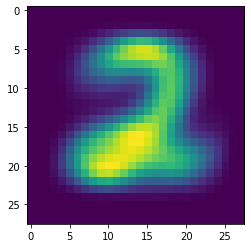

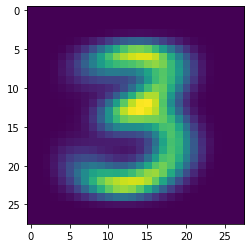

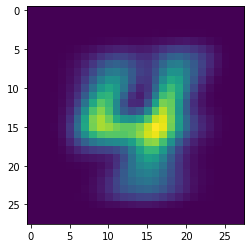

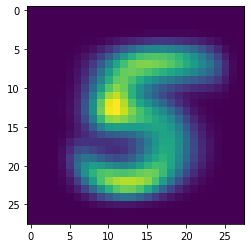

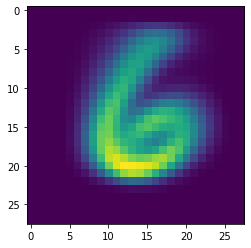

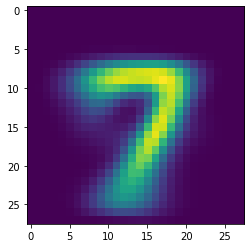

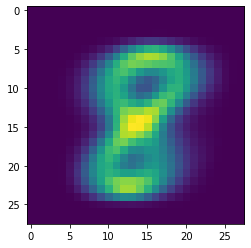

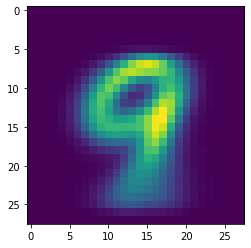

In [7]:
#Generate prototype number for each label
for i in range(0,10,1):
    form_mean_image(train,i)

In [8]:
#split training data
X_train, y_train = split_X_y(train)

#split testing data
X_test, y_test = split_X_y(test)

X_train[2 == y_train].shape

(5958, 784)

In [9]:
#Call Gaussian constructor
gb_model = GaussBayes()

#Fit guassian model to trianing data
gb_model.fit(X_train,y_train)

#Predict using guassian model on test data
y_hat_gb = gb_model.predict(X_test)

#compute accuracy
accuracy(y_test, y_hat_gb)

0.9108

In [42]:
#Call Multinomial Constructor
mnnb_model = MultinomialNiaveBayes()

#Make multinomial fit o ntraining data
mnnb_model.fit(X_train,y_train)

#Multinomial predict on testing data
y_hat_mnnb = mnnb_model.predict(X_test)

#compute accuracy
accuracy(y_test, y_hat_mnnb)

0.8055

In [43]:
#generate confusion matrix
con = confusionMatrix(y_test,y_hat_gb)
print(con)

     0     1    2    3    4    5    6    7    8    9
0  951     0    3    7    0    4    4    2    9    0
1    0  1098    8    3    1    0    6    0   19    0
2    8     3  942   17    4    1    3    4   49    1
3    8     0    9  904    1    9    0    5   60   14
4    1     0   13    2  877    0    4    5   12   68
5    7     0    2   40    2  732   12    2   85   10
6   11     2    4    0    5   14  903    0   19    0
7    0     7   12   10   17    1    0  872   16   93
8    9     6    9   23    4    7    3    4  897   12
9    5     5    5    9   11    0    0   20   22  932


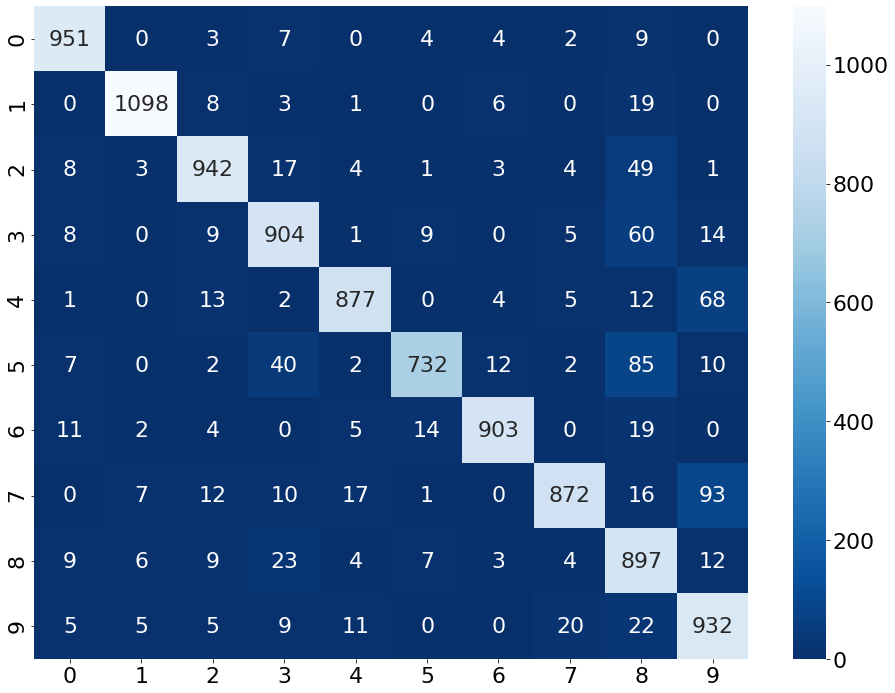

In [61]:
fig1 = plt.figure(figsize=(16,12))
ax = sns.heatmap(con, annot=True, cmap ='Blues_r' ,fmt='d')
plt.show()